# Day 7: Week 9 Review - Unsupervised Learning

## 🎯 Learning Objectives
- Review all unsupervised methods
- Compare clustering approaches
- Build comprehensive regime detection system

---

## 📚 Week Summary

| Day | Topic | Key Concept |
|-----|-------|-------------|
| 1 | K-Means | Centroid-based clustering |
| 2 | Hierarchical | Dendrogram, HRP portfolio |
| 3 | PCA | Factor extraction |
| 4 | DBSCAN | Density-based, anomaly detection |
| 5 | GMM | Soft clustering, distributions |
| 6 | t-SNE/UMAP | Visualization |

---

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import warnings
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import squareform

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')

TRADING_DAYS = 252
RISK_FREE_RATE = 0.05

# Download data
ticker = 'SPY'
end_date = datetime.now()
start_date = end_date - timedelta(days=10*365)

print("📥 Downloading data...")
data = yf.download(ticker, start=start_date, end=end_date, progress=False, auto_adjust=True)
prices = data['Close']
returns = prices.pct_change().dropna()

print(f"✅ Data: {len(prices)} days")

📥 Downloading data...
✅ Data: 2513 days


In [2]:
# Create feature set
df = pd.DataFrame(index=returns.index)
df['return'] = returns
df['return_20d'] = returns.rolling(20).mean()
df['volatility_20d'] = returns.rolling(20).std() * np.sqrt(TRADING_DAYS)
df['momentum_20d'] = prices.pct_change(20)
df['volume_20d'] = data['Volume'].rolling(20).mean().pct_change(20)

df = df.dropna()
feature_cols = ['return_20d', 'volatility_20d', 'momentum_20d']

X = df[feature_cols].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"📊 Samples: {len(df)}")

📊 Samples: 2474


In [3]:
# Apply all clustering methods
n_clusters = 3

# 1. K-Means
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
df['kmeans'] = kmeans.fit_predict(X_scaled)

# 2. GMM
gmm = GaussianMixture(n_components=n_clusters, random_state=42)
df['gmm'] = gmm.fit_predict(X_scaled)

# 3. Hierarchical
Z = linkage(X_scaled, method='ward')
df['hierarchical'] = fcluster(Z, n_clusters, criterion='maxclust') - 1

# 4. DBSCAN
dbscan = DBSCAN(eps=1.5, min_samples=5)
df['dbscan'] = dbscan.fit_predict(X_scaled)

print("\n" + "="*60)
print("CLUSTERING RESULTS")
print("="*60)

methods = ['kmeans', 'gmm', 'hierarchical', 'dbscan']
for method in methods:
    n_clusters_found = df[method].nunique()
    if method == 'dbscan':
        n_outliers = (df[method] == -1).sum()
        print(f"\n{method.upper()}: {n_clusters_found} clusters, {n_outliers} outliers")
    else:
        score = silhouette_score(X_scaled, df[method])
        print(f"\n{method.upper()}: {n_clusters_found} clusters, Silhouette: {score:.3f}")


CLUSTERING RESULTS

KMEANS: 3 clusters, Silhouette: 0.507

GMM: 3 clusters, Silhouette: 0.411

HIERARCHICAL: 3 clusters, Silhouette: 0.542

DBSCAN: 6 clusters, 10 outliers


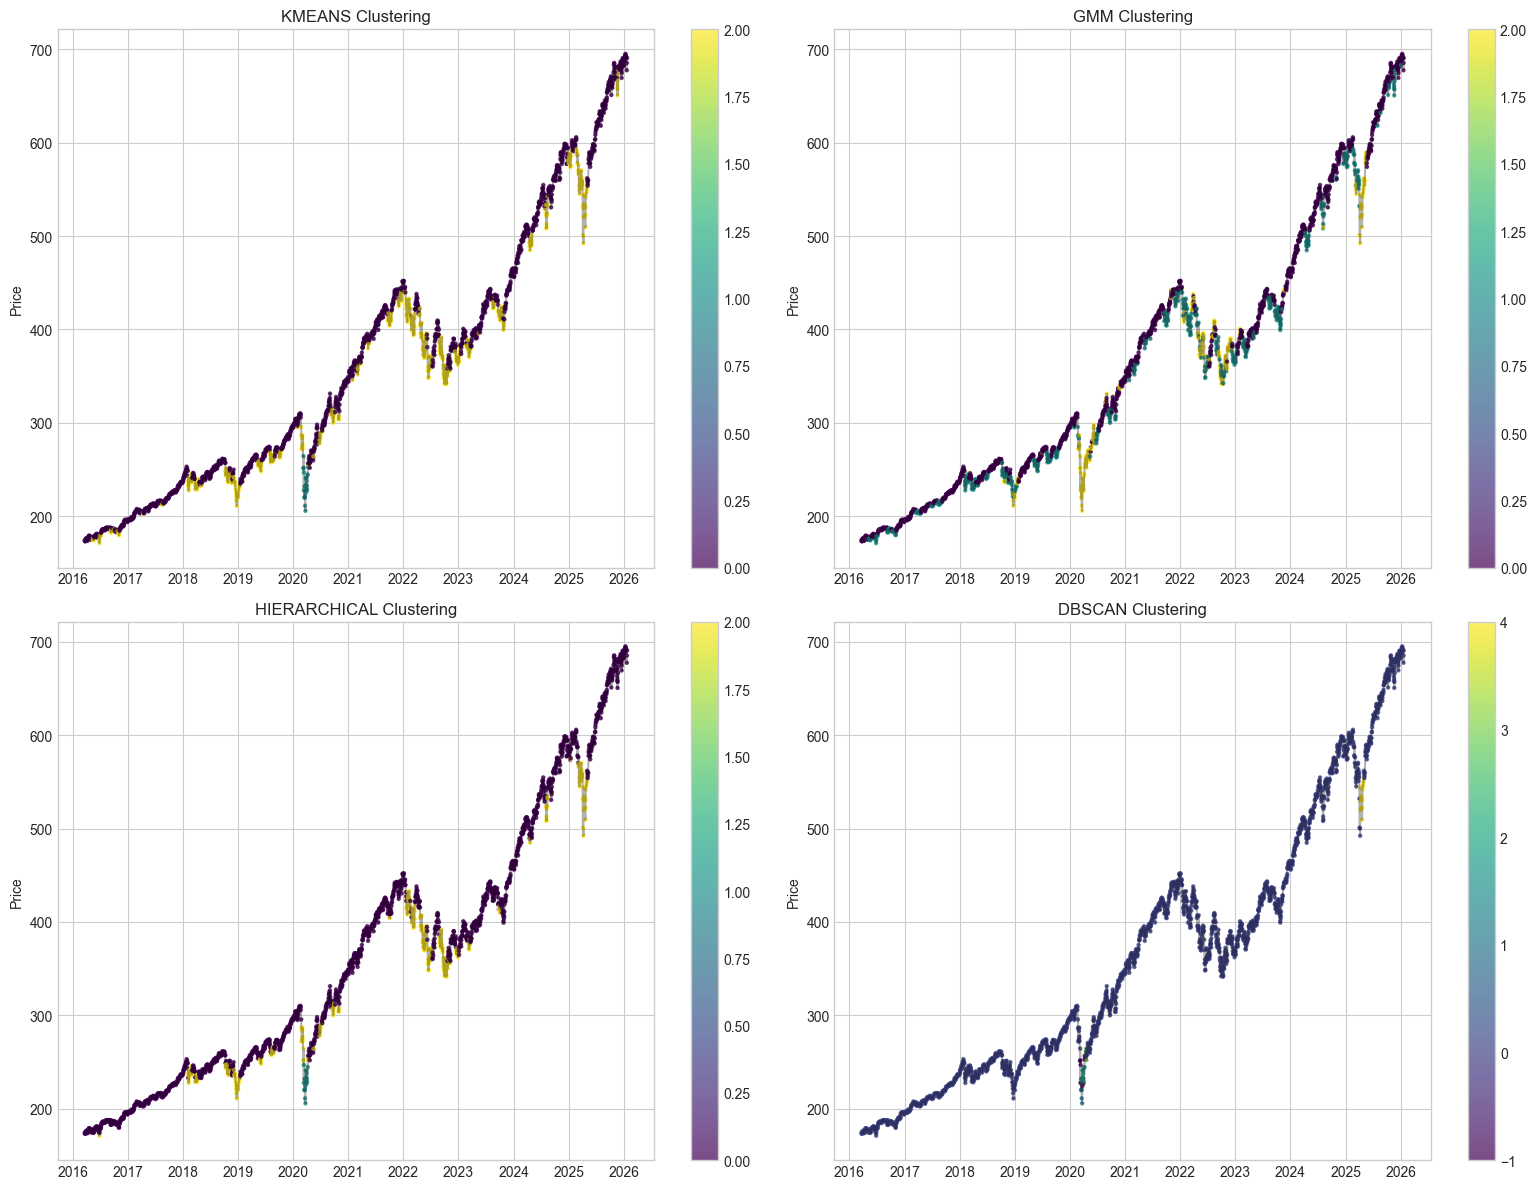

In [4]:
# Compare clustering results
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

price_aligned = prices.loc[df.index]

for ax, method in zip(axes.flatten(), methods):
    ax.plot(price_aligned.index, price_aligned.values, 'k-', alpha=0.3)
    scatter = ax.scatter(df.index, price_aligned.values, c=df[method], cmap='viridis', s=5, alpha=0.7)
    ax.set_title(f'{method.upper()} Clustering')
    ax.set_ylabel('Price')
    plt.colorbar(scatter, ax=ax)

plt.tight_layout()
plt.show()

In [5]:
# Ensemble clustering: Majority vote
from scipy import stats

# Align labels (since cluster numbers may differ)
def align_labels(labels, reference_labels):
    aligned = labels.copy()
    for old_label in np.unique(labels):
        mask = labels == old_label
        most_common = stats.mode(reference_labels[mask], keepdims=True)[0][0]
        aligned[mask] = most_common
    return aligned

reference = df['kmeans'].values
df['gmm_aligned'] = align_labels(df['gmm'].values, reference)
df['hier_aligned'] = align_labels(df['hierarchical'].values, reference)

# Ensemble (excluding DBSCAN due to outliers)
ensemble = np.vstack([df['kmeans'], df['gmm_aligned'], df['hier_aligned']]).T
df['ensemble'] = stats.mode(ensemble, axis=1, keepdims=True)[0].flatten()

print("\n📊 Ensemble clustering applied")


📊 Ensemble clustering applied


In [6]:
# Build trading strategy with ensemble regimes
df['next_return'] = df['return'].shift(-1)

# Analyze ensemble regimes
regime_stats = df.groupby('ensemble').agg({
    'return': ['mean', 'std', 'count'],
    'volatility_20d': 'mean'
}).round(4)

print("\n" + "="*60)
print("ENSEMBLE REGIME ANALYSIS")
print("="*60)
print(regime_stats)

# Label regimes
regime_labels = {}
for r in df['ensemble'].unique():
    avg_ret = df[df['ensemble'] == r]['return_20d'].mean()
    if avg_ret > 0.0001:
        regime_labels[r] = 'Bull'
    elif avg_ret < -0.0001:
        regime_labels[r] = 'Bear'
    else:
        regime_labels[r] = 'Sideways'

df['regime_label'] = df['ensemble'].map(regime_labels)
print(f"\nRegime Labels: {regime_labels}")


ENSEMBLE REGIME ANALYSIS
          return               volatility_20d
            mean     std count           mean
ensemble                                     
0         0.0014  0.0080  1864         0.1227
1        -0.0037  0.0558    18         0.8491
2        -0.0018  0.0153   592         0.2066

Regime Labels: {np.int64(0): 'Bull', np.int64(2): 'Bear', np.int64(1): 'Bear'}


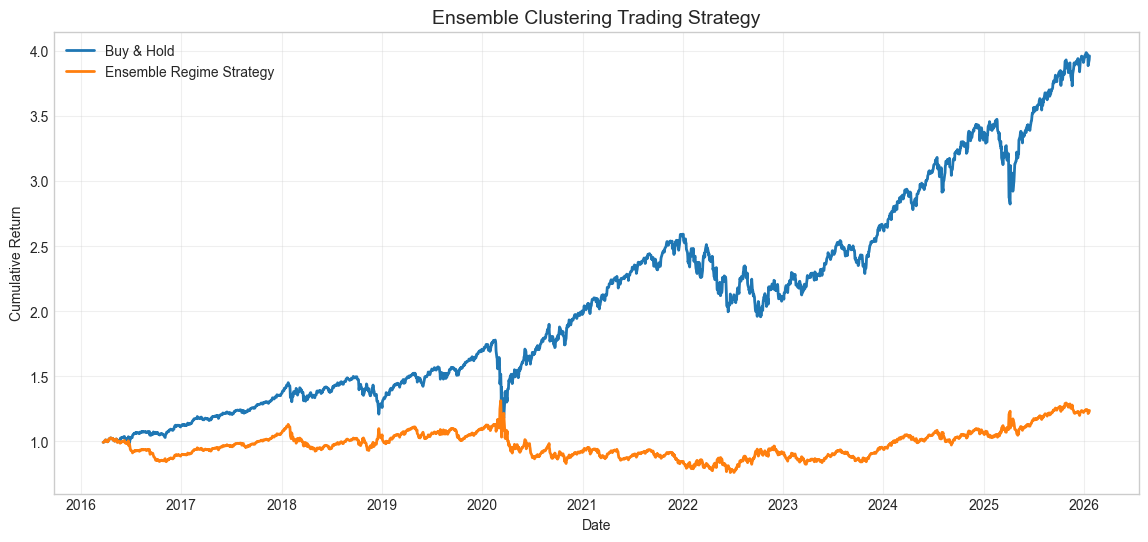

In [7]:
# Strategy: Long in Bull, Short in Bear, Out in Sideways
df['signal'] = df['regime_label'].map({'Bull': 1, 'Bear': -1, 'Sideways': 0})
df['strategy_return'] = df['signal'] * df['next_return']

df = df.dropna()
df['strategy_cum'] = (1 + df['strategy_return']).cumprod()
df['buy_hold_cum'] = (1 + df['next_return']).cumprod()

plt.figure(figsize=(14, 6))
plt.plot(df.index, df['buy_hold_cum'], label='Buy & Hold', linewidth=2)
plt.plot(df.index, df['strategy_cum'], label='Ensemble Regime Strategy', linewidth=2)
plt.title('Ensemble Clustering Trading Strategy', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [8]:
# Performance comparison across all methods
def calc_metrics(returns, cumulative):
    total = cumulative.iloc[-1] - 1
    sharpe = (returns.mean() * TRADING_DAYS - RISK_FREE_RATE) / (returns.std() * np.sqrt(TRADING_DAYS)) if returns.std() > 0 else 0
    peak = cumulative.cummax()
    mdd = ((cumulative - peak) / peak).min()
    return total, sharpe, mdd

print("\n" + "="*60)
print("STRATEGY COMPARISON")
print("="*60)

# Test each clustering method
results = []
for method in ['kmeans', 'gmm_aligned', 'hier_aligned', 'ensemble']:
    # Label regimes
    method_labels = {}
    for r in df[method].unique():
        avg_ret = df[df[method] == r]['return_20d'].mean()
        if avg_ret > 0.0001:
            method_labels[r] = 1
        elif avg_ret < -0.0001:
            method_labels[r] = -1
        else:
            method_labels[r] = 0
    
    signal = df[method].map(method_labels)
    strat_ret = signal * df['next_return']
    strat_cum = (1 + strat_ret).cumprod()
    
    total, sharpe, mdd = calc_metrics(strat_ret, strat_cum)
    results.append({'Method': method.replace('_aligned', ''), 'Total': total, 'Sharpe': sharpe, 'MaxDD': mdd})

# Add buy & hold
bh_total, bh_sharpe, bh_mdd = calc_metrics(df['next_return'], df['buy_hold_cum'])
results.append({'Method': 'Buy & Hold', 'Total': bh_total, 'Sharpe': bh_sharpe, 'MaxDD': bh_mdd})

results_df = pd.DataFrame(results)
print(f"\n{'Method':<15} {'Total Ret':>12} {'Sharpe':>10} {'Max DD':>10}")
print("-" * 50)
for _, row in results_df.iterrows():
    print(f"{row['Method']:<15} {row['Total']:>12.2%} {row['Sharpe']:>10.2f} {row['MaxDD']:>10.2%}")


STRATEGY COMPARISON

Method             Total Ret     Sharpe     Max DD
--------------------------------------------------
kmeans                44.29%       0.02    -39.47%
gmm                  138.35%       0.30    -31.33%
hier                  98.04%       0.20    -32.62%
ensemble              23.76%      -0.07    -42.09%
Buy & Hold           296.37%       0.59    -33.72%


In [9]:
# Current signal from all methods
print("\n" + "="*60)
print(f"📊 TODAY'S TRADING SIGNAL FOR {ticker}")
print("="*60)
print(f"\nDate: {df.index[-1].strftime('%Y-%m-%d')}")
print(f"Current Price: ${float(prices.iloc[-1]):.2f}")

print(f"\nMethod Signals:")
print(f"  K-Means: Cluster {df['kmeans'].iloc[-1]}")
print(f"  GMM: Cluster {df['gmm'].iloc[-1]}")
print(f"  Hierarchical: Cluster {df['hierarchical'].iloc[-1]}")
print(f"  DBSCAN: {'Outlier' if df['dbscan'].iloc[-1] == -1 else f'Cluster {df["dbscan"].iloc[-1]}'}")

current_regime = df['regime_label'].iloc[-1]
signal = df['signal'].iloc[-1]

print(f"\n🎯 ENSEMBLE SIGNAL:")
print(f"  Current Regime: {current_regime}")
print(f"  Position: {'📈 LONG' if signal == 1 else '📉 SHORT' if signal == -1 else '⏸️ CASH'}")
print(f"\n  20d Return: {df['return_20d'].iloc[-1]:.2%}")
print(f"  20d Volatility: {df['volatility_20d'].iloc[-1]:.1%}")
print(f"  20d Momentum: {df['momentum_20d'].iloc[-1]:.2%}")


📊 TODAY'S TRADING SIGNAL FOR SPY

Date: 2026-01-21
Current Price: $690.74

Method Signals:
  K-Means: Cluster 0
  GMM: Cluster 0
  Hierarchical: Cluster 0
  DBSCAN: Cluster 0

🎯 ENSEMBLE SIGNAL:
  Current Regime: Bull
  Position: 📈 LONG

  20d Return: 0.04%
  20d Volatility: 10.7%
  20d Momentum: 0.71%


---

## 🏢 Interview Questions

### Q1: When to use each clustering method?
| Method | Use When |
|--------|----------|
| K-Means | Known k, spherical clusters |
| Hierarchical | Need hierarchy, unknown k |
| GMM | Soft assignments, probabilistic |
| DBSCAN | Arbitrary shapes, outliers |

### Q2: How do you validate unsupervised learning?
- Silhouette score
- Domain expertise validation
- Downstream task performance
- Stability across samples

### Q3: PCA vs t-SNE?
- PCA: Linear, preserves variance, interpretable
- t-SNE: Non-linear, preserves local structure, visualization only

---
## 📅 Next Week: Time Series Models